# Setup

In [1]:
!pip install --upgrade --force-reinstall --no-deps --quiet kaggle

     |████████████████████████████████| 58 kB 3.0 MB/s 


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c happy-whale-and-dolphin -p /content/happywhale

In [ ]:
!unzip -q /content/happywhale/*.zip -d /content/happywhale/

In [ ]:
!rm /content/happywhale/*.zip

# Load Tfrecord

In [5]:
import tensorflow as tf

In [6]:
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'species_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'individual_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'family_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
    # .parse_example if batched
    parsed_ex = tf.io.parse_single_example(example_proto, feature_description)
    parsed_ex['image'] = tf.io.parse_tensor(parsed_ex['image'], tf.uint8)
    return parsed_ex

In [7]:
fname = ['/content/drive/MyDrive/happywhale.tfrecord']
raw_ds = tf.data.TFRecordDataset(fname)
raw_ds

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [8]:
parsed_ds = raw_ds.map(_parse_function)

In [10]:
next(iter(parsed_ds)).keys()

dict_keys(['family_name', 'image', 'image_name', 'individual_id', 'species_name'])

# EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!ls /content/happywhale/

In [ ]:
train_csv_path = '/content/happywhale/train.csv'
train_df = pd.read_csv(train_csv_path)

In [ ]:
train_df.head()

In [ ]:
fig, ax = plt.subplots(1,1)
train_df['species'].value_counts().plot(ax=ax, kind='bar')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

In [ ]:
train_df['species'].value_counts().sum()

As seen above, we have an uneven distribution of classes - can resample to balance out training.

In [ ]:
class_weights = train_df['species'].value_counts()
class_weights = class_weights / class_weights.sum()
class_weights = class_weights[0] / class_weights

## Observe Images

In [ ]:
import os
import glob
import tensorflow as tf
from tensorflow.data import Dataset

In [ ]:
train_df.head()

In [ ]:
train_paths = glob.glob("/content/happywhale/train_images/*.jpg")
train_img_names = [path.split(os.path.sep)[-1] for path in train_paths]
train_species_names = (train_df.set_index('image').loc[train_img_names])['species']
train_ids = (train_df.set_index('image').loc[train_img_names])['individual_id']

In [ ]:
ds = Dataset.from_tensor_slices((train_paths, train_img_names, train_species_names, train_ids))
N = tf.data.experimental.cardinality(ds).numpy()
val_size = int(N * 0.2)
train_ds = ds.skip(val_size)
val_ds = ds.take(val_size)

IMG_HEIGHT = 128
IMG_WIDTH = 128
def get_family_name(species_name):
    parts = tf.strings.split(species_name, '_')
    if (parts[-1] == b'whale') or \
       (parts[-1] == b'beluga') or \
       (parts[-1] == b'globis'):
       family_name = 'whale'
    elif (parts[-1] == b'dolphin') or \
         (parts[-1] == b'dolpin'):
         family_name = 'dolphin'
    else:
        family_name = 'unknown'
    return family_name

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.cast(img, tf.uint8)
    return img

def cast_to_float(img):
    return tf.cast(img, tf.float32) / 255.

ds = ds.map(lambda w,x,y,z: {'image': load_img(w),
                             'image_name': x,
                             'species_name': y,
                             'individual_id': z,
                             'family_name': get_family_name(y)}, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(lambda w,x,y,z: {'image': load_img(w),
                                         'image_name': x,
                                         'species_name': y,
                                         'individual_id': z,
                                         'family_name': get_family_name(y)}, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda w,x,y,z: {'image': load_img(w),
                                     'image_name': x,
                                     'species_name': y,
                                     'individual_id': z,
                                     'family_name': get_family_name(y)}, num_parallel_calls=tf.data.AUTOTUNE)

# Cache as 8bit int to save on speed (loading very large images is slow)
train_ds = train_ds.cache()
val_ds = val_ds.cache()

# Then convert to 32bit float
train_ds = train_ds.map(lambda data: {'image': cast_to_float(data['image']),
                                      'image_name': data['image_name'],
                                      'species_name': data['species_name'],
                                      'individual_id': data['individual_id'],
                                      'family_name': data['family_name']})

val_ds = val_ds.map(lambda data: {'image': cast_to_float(data['image']),
                                  'image_name': data['image_name'],
                                  'species_name': data['species_name'],
                                  'individual_id': data['individual_id'],
                                  'family_name': data['family_name']})

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(10,10)); axs = axs.flatten()
for sample,ax in zip(train_ds.take(9),axs):
    ax.imshow(sample['image'])
    ax.set_title(sample['species_name'].numpy().decode())

As seen above, some images are well centered, others are not. Some images are comprised of fins for dolphins while the whales are blunt.

Consider cropping images to get rid of needless background (water, land, etc.)

Consider first identifying whether dolphin or whale (fin or blunt)
* would assume that the machine would use those features to tell them apart (can confirm using gradient tracing), could then be used to crop

## TFRecords

https://www.kaggle.com/ks2019/happywhale-tfrecords

In [ ]:
import os, json, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf, re, math
from tqdm import tqdm

In [ ]:
next(iter(ds)).keys()

In [ ]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # EagerTensor unpackable
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_array_feature(nonscalar):
    if isinstance(nonscalar, type(tf.constant(0))):
        nonscalar = nonscalar.numpy()
    serialized_nonscalar = tf.io.serialize_tensor(nonscalar)
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_nonscalar.numpy()]))

def serialize_example(image, image_name, species_name, individual_id, family_name):
    feature = {
        'image': _bytes_array_feature(image),
        'image_name': _bytes_feature(image_name),
        'species_name': _bytes_feature(species_name),
        'individual_id': _bytes_feature(individual_id),
        'family_name': _bytes_feature(family_name)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tf_serialize_example(data_dict):
    tf_string = tf.py_function(
        serialize_example,
        (data_dict['image'],
         data_dict['image_name'],
         data_dict['species_name'],
         data_dict['individual_id'],
         data_dict['family_name']),
         tf.string
    )
    return tf.reshape(tf_string, ()) # Res is scalar

feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'image_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'species_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'individual_id': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'family_name': tf.io.FixedLenFeature([], tf.string, default_value=''),
}

def _parse_function(example_proto):
    # .parse_example if batched
    parsed_ex = tf.io.parse_single_example(example_proto, feature_description)
    parsed_ex['image'] = tf.io.parse_tensor(parsed_ex['image'], tf.uint8)
    return parsed_ex

serial_ex = tf_serialize_example(next(iter(ds)))
print(serial_ex)
print(_parse_function(serial_ex))

In [ ]:
serialized_ds = ds.map(tf_serialize_example)

In [ ]:
fname = 'happywhale.tfrecord'
writer = tf.data.experimental.TFRecordWriter(fname)
writer.write(serialized_ds)

#### Read TFRecord

In [ ]:
fname = ['/content/drive/MyDrive/happywhale.tfrecord']
raw_ds = tf.data.TFRecordDataset(fname)
raw_ds

In [ ]:
parsed_ds = raw_ds.map(_parse_function)

In [ ]:
next(iter(parsed_ds))

## Model to Differentiate b/w Whale and Dolphin

In [ ]:
train_types = train_df['species'].apply(lambda x: x.split('_')[-1])
train_types = train_types.value_counts()
train_types

In [ ]:
num_whale = (26479 + 7443 + 116)
num_dolph = (15878 + 1117)
num_whale / (num_whale + num_dolph)

Note that beluga and globis are whales, and 'dolpin' is a misspelling of 'dolphin'

In [ ]:
family_types = np.array(['whale', 'dolphin'])

In [ ]:
def encode_family_name(family_name):
    tar = family_name == family_types
    tar = tf.argmax(tar)
    return tar

BSZ = 32
train_wd_ds = train_ds.map(lambda data: {'image': data['image'],
                                         'tar': encode_family_name(data['family_name'])})
train_wd_ds = train_wd_ds.batch(BSZ)

val_wd_ds = val_ds.map(lambda data: {'image': data['image'],
                                     'tar': encode_family_name(data['family_name'])})
val_wd_ds = val_wd_ds.batch(BSZ)

In [ ]:
fig, ax = plt.subplots(1,1)
sample = next(iter(train_wd_ds))
ax.imshow(sample['image'][0])
_ = ax.set_title(family_types[sample['tar'][0]])

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
basemodel = keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(IMG_HEIGHT,IMG_WIDTH,3), pooling=None,
)

In [ ]:
num_layers = len(basemodel.layers)
freeze_cnt = int(num_layers *  .8)
for layer in basemodel.layers[:freeze_cnt]:
    layer.trainable = False

In [ ]:
print(len(basemodel.trainable_weights))
print(num_layers)
print(freeze_cnt)
print(num_layers - freeze_cnt)

In [ ]:
print("Input Shapes:", [inp.shape for inp in basemodel.inputs])
print("Output Shapes:", [out.shape for out in basemodel.outputs])

In [ ]:
output_shape = basemodel.outputs[0].shape
output_shape[1], output_shape[2]

In [ ]:
class WD_Model(keras.Model):
    def __init__(self, basemodel):
        super(WD_Model, self).__init__()
        self.basemodel = basemodel # :: (None, 8, 8, 1280)
        self.baseoutshape = basemodel.output_shape
        self.pooling2d = layers.AvgPool2D((self.baseoutshape[1], self.baseoutshape[2])) # :: (None, 1, 1, 1280)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(64, activation='relu')
        self.classlogit = layers.Dense(1)

    def call(self, image):
        # image :: (None, 256, 256, 3)
        x = self.basemodel(image)
        #x = self.pooling2d(x)
        x = self.flatten(x)
        #x = self.dense(x)
        out = self.classlogit(x) # :: (None, 1)
        return out

    @tf.function
    def train_step(self, sample):
        image = sample['image']
        tar = sample['tar']

        with tf.GradientTape() as tape:
            out = self.call(image)
            out = tf.squeeze(out) # :: (None,)
            loss = keras.losses.binary_crossentropy(tar, out, from_logits=True)

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(tf.cast(tf.sigmoid(out) > 0.5, tf.int32), tar)
        return {'loss': loss, 'acc': self.metrics[0].result()}

    @tf.function
    def test_step(self, sample):
        image = sample['image']
        tar = sample['tar']

        out = self.call(image)
        out = tf.squeeze(out) # :: (None,)
        loss = keras.losses.binary_crossentropy(tar, out, from_logits=True)

        self.compiled_metrics.update_state(tf.cast(tf.sigmoid(out) > 0.5, tf.int32), tar)
        return {'loss': loss, 'acc': self.metrics[0].result()}

In [ ]:
fresh_basemodel = tf.keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(8, (3,3)),
    layers.Conv2D(16, (3,3)),
    layers.Conv2D(32, (3,3)),
    layers.Conv2D(64, (3,3))
])

In [ ]:
wd_model = WD_Model(fresh_basemodel)
wd_model.compile(optimizer='adam',
                 metrics=keras.metrics.BinaryAccuracy())

In [ ]:
wd_model.train_step(next(iter(train_wd_ds)))

In [ ]:
_ = wd_model(sample['image'])
wd_model.summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                                              patience = 5, mode = 'min', verbose = 1,
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                                                 patience = 2, min_delta = 0.001, 
                                                 mode = 'min', verbose = 1)

In [ ]:
history = wd_model.fit(train_wd_ds, epochs=50,
                       validation_data=val_wd_ds,
                       callbacks=[early_stop, reduce_lr])

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1,1)
    keys = {'loss', 'acc'}
    for key in keys:
        ax.plot(history.history[key], label=key)
        ax.plot(history.history["val_"+key], label="val_"+key)
    fig.legend()

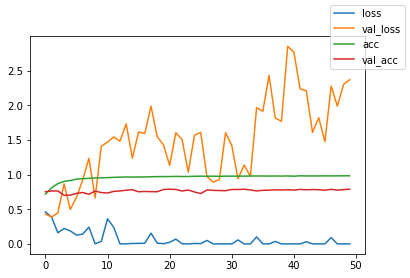

In [ ]:
plot_history(history)

## Qubvel: Segmentation Models

* python 3
* keras >= 2.2.0 or tensorflow >= 1.13
* keras-applications >= 1.0.7, <=1.0.8
* image-classifiers == 1.0.*
* efficientnet == 1.0.*

In [ ]:
!python --version
print(tf.version.VERSION)
print(keras.__version__)

Python 3.7.12
2.8.0
2.8.0


In [ ]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 6.7 MB/s 


In [ ]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
model = sm.Unet('resnet34', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), encoder_weights='imagenet',
                classes=1, activation='sigmoid')

85532672/85521592 [==============================] - 2s 0us/step


In [ ]:
res = model(sample['image'])

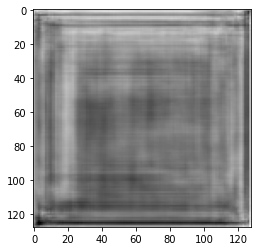

In [ ]:
plt.imshow(res[0,...,0], cmap='gray')

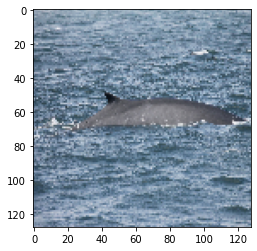

In [ ]:
plt.imshow(sample['image'][0])

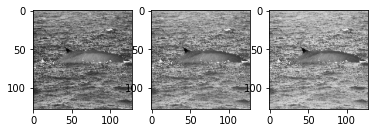

In [ ]:
t_img = sample['image'][0]
fig, axs = plt.subplots(1,3); axs = axs.flatten()
for i in range(3):
    axs[i].imshow(t_img[...,i], cmap='gray')

In [ ]:
import cv2

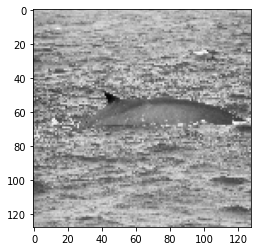

In [ ]:
res = cv2.fastNlMeansDenoising((t_img[...,2].numpy() * 255).astype(np.uint8))
plt.imshow(res, cmap='gray')

## Otsu's Method

In [ ]:
import cv2

In [ ]:
image = (sample['image'][0].numpy() * 255).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
image = cv2.GaussianBlur(image, (5,5), 0)

In [ ]:

otsu_threshold, image_result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(otsu_threshold)

137.0


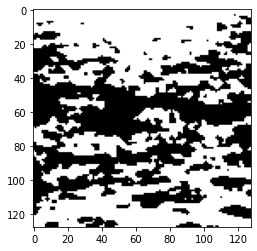

In [ ]:
plt.imshow(image_result, cmap='gray')

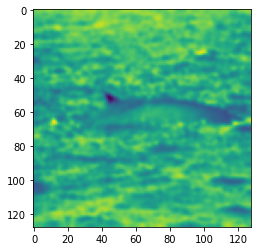

In [ ]:
plt.imshow(image)

## 3D Polyhedron-Based Color Segmentation

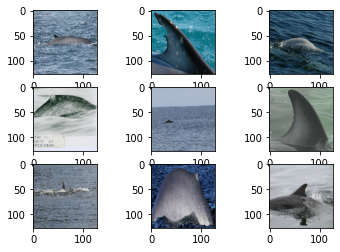

In [ ]:
fig, axs = plt.subplots(3,3); axs = axs.flatten()
for i in range(9):
    axs[i].imshow(sample['image'][i])

## Autoencoder Technique
* Encoded representation has vals for individual id as well as vals for the details of that specific image
* Using loss function, ensure the specific id vals arent all identical (how?)

In [ ]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    
        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def train_step(self, sample):
        x,ty,tz = ...
        x = self.encoder(x)
        y,z = x.split
        loss1 = loss1_fn()
        x = self.decoder(x)




autoencoder = Autoencoder()